# 3.0 - baseline

In this notebook I basically copy NGCF and LightGCN models from [here](https://medium.com/stanford-cs224w/recommender-systems-with-gnns-in-pyg-d8301178e377) and evaluate them on dataset to get a baseline.


In [1]:
import sys
import torch
import pandas as pd
import matplotlib.pyplot as plt

sys.path.append("../")

from benchmark.train import train_and_eval, TrainParameters, device  # noqa: E402
from benchmark.models import RecSysGNN  # noqa: E402

In [2]:
# load dataframes
train = pd.read_csv("../data/interim/train.csv")
test = pd.read_csv("../data/interim/test.csv")

In [3]:
PARAMETERS = TrainParameters(
    EPOCHS=20,
    BATCH_SIZE=1024,
    LR=5e-4,
    DECAY=1e-4,
    K=20,
)

In [4]:
latent_dim = 64
n_layers = 3

n_users = train.user_id_idx.nunique()
n_items = train.item_id_idx.nunique()

lightgcn = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
    model="LightGCN",
)
lightgcn.to(device)

optimizer = torch.optim.Adam(lightgcn.parameters(), lr=PARAMETERS.LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(lightgcn.parameters())])

Size of Learnable Embedding :  [torch.Size([2598, 64])]


In [6]:
light_loss, light_bpr, light_reg, light_recall, light_precision = train_and_eval(
    lightgcn, optimizer, train, test, PARAMETERS
)

  0%|          | 0/20 [00:00<?, ?it/s]/home/leo/github.com/lvjonok/f23-pmldl-recommender/notebooks/../benchmark/metrics.py:35: UserWarning: torch.sparse.SparseTensor(indices, values, shape, *, device=) is deprecated.  Please use torch.sparse_coo_tensor(indices, values, shape, dtype=, device=). (Triggered internally at /opt/conda/conda-bld/pytorch_1699449201450/work/torch/csrc/utils/tensor_new.cpp:605.)
  torch.sparse.FloatTensor(i, v, (n_users, n_items)).to_dense().to(device)
100%|██████████| 20/20 [02:10<00:00,  6.51s/it]


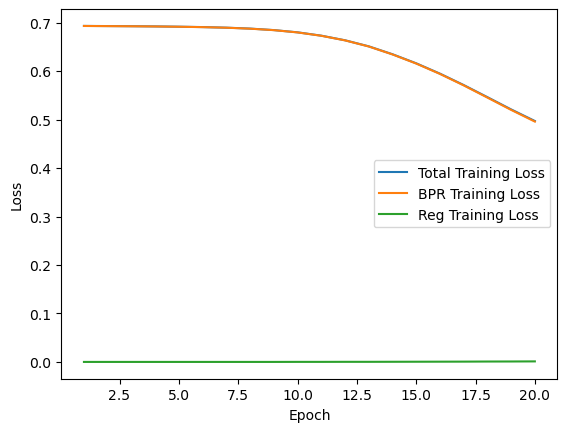

In [7]:
epoch_list = [(i + 1) for i in range(PARAMETERS.EPOCHS)]
plt.plot(epoch_list, light_loss, label="Total Training Loss")
plt.plot(epoch_list, light_bpr, label="BPR Training Loss")
plt.plot(epoch_list, light_reg, label="Reg Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

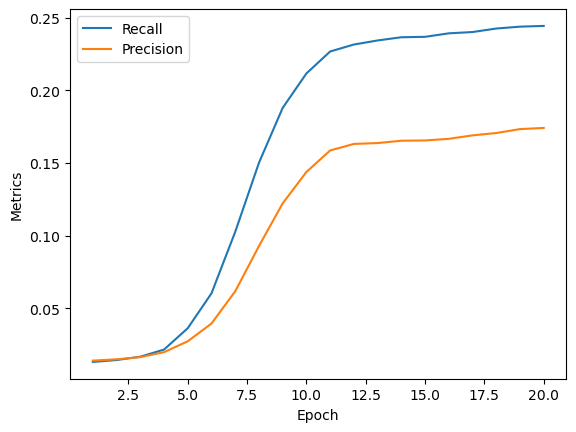

In [8]:
plt.plot(epoch_list, light_recall, label='Recall')
plt.plot(epoch_list, light_precision, label='Precision')
plt.xlabel('Epoch')
plt.ylabel('Metrics')
plt.legend()

In [9]:
ngcf = RecSysGNN(
    latent_dim=latent_dim,
    num_layers=n_layers,
    num_users=n_users,
    num_items=n_items,
    model="NGCF",
)
ngcf.to(device)

optimizer = torch.optim.Adam(ngcf.parameters(), lr=PARAMETERS.LR)
print("Size of Learnable Embedding : ", [x.shape for x in list(ngcf.parameters())])

Size of Learnable Embedding :  [torch.Size([2598, 64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64]), torch.Size([64, 64]), torch.Size([64])]


In [11]:
ngcf_loss, ngcf_bpr, ngcf_reg, ngcf_recall, ngcf_precision = train_and_eval(
    ngcf, optimizer, train, test, PARAMETERS
)

  0%|          | 0/20 [00:00<?, ?it/s]

100%|██████████| 20/20 [04:17<00:00, 12.89s/it]


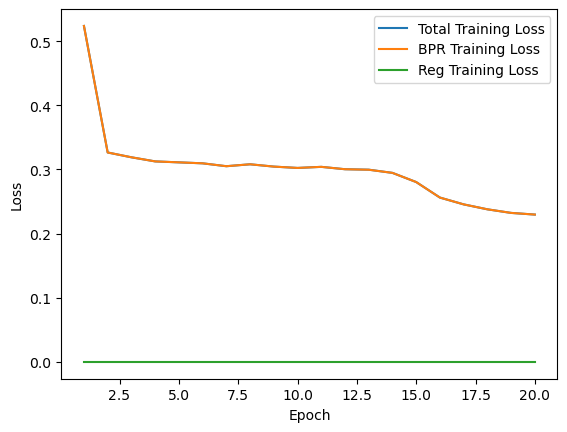

In [12]:
epoch_list = [(i + 1) for i in range(PARAMETERS.EPOCHS)]
plt.plot(epoch_list, ngcf_loss, label="Total Training Loss")
plt.plot(epoch_list, ngcf_bpr, label="BPR Training Loss")
plt.plot(epoch_list, ngcf_reg, label="Reg Training Loss")

plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()

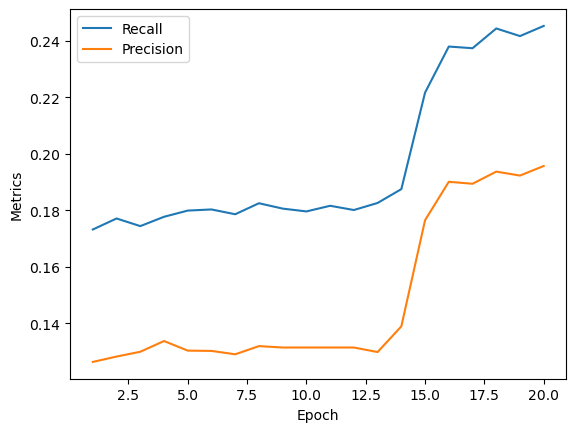

In [13]:
plt.plot(epoch_list, ngcf_recall, label="Recall")
plt.plot(epoch_list, ngcf_precision, label="Precision")
plt.xlabel("Epoch")
plt.ylabel("Metrics")
plt.legend()

In [14]:
max(light_precision), max(light_recall)

(0.1741, 0.2443)

In [15]:
max(ngcf_precision), max(ngcf_recall)

(0.1957, 0.2453)